## Import Libraries

In [2]:
# import Libraries
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
import keras.backend as K

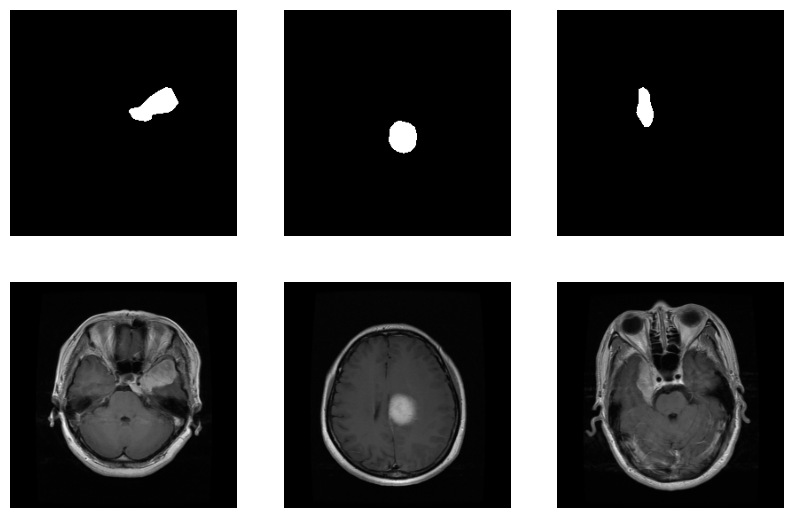

In [5]:
# Set image dimensions and dataset path
SIZE_X = 256
SIZE_Y = 256
TRAIN_PATH = '/kaggle/input/brain-tumor-segmentation'

# Load and preprocess image data
images = []
for directory_path in sorted(glob.glob(TRAIN_PATH + '/images/')):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.uint8)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.merge([img, img, img])
        images.append(img)

images = np.array(images)

# Load and preprocess mask data
masks = [] 
for directory_path in sorted(glob.glob(TRAIN_PATH + '/masks/')):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        mask = mask / 255
        mask = mask.astype(np.uint8)
        masks.append(mask)

masks = np.array(masks)

# Display sample masks and images
n_samples = 3
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(masks[i], cmap='gray')

for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray')

plt.show()


In [6]:
# Add a channel dimension to the masks
y = np.expand_dims(masks, axis = -1)

print(y.shape)

(3064, 256, 256, 1)


In [7]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

# Reshape masks to 2D and encode labels
n, h, w = masks.shape
train_masks_reshaped = masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())

# Reshape back to original mask shape
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# Print unique labels and shape
print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)


[0 1]
(3064, 256, 256)


In [8]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = -1)
print(train_masks_input.shape)

(3064, 256, 256, 1)


In [9]:
from sklearn.model_selection import train_test_split

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input, 
                                                    test_size=0.2, shuffle=True, random_state=42)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

from tensorflow.keras.utils import to_categorical


n_classes = 2
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
val_masks_cat = to_categorical(y_val, num_classes=n_classes)

# Print dataset shapes
print(f'TRAIN SET:\n'
      f'X_train shape: {X_train.shape}\n'
      f'y_train shape: {train_masks_cat.shape}\n\n'
      f'VALIDATION SET:\n'
      f'X_val shape: {X_val.shape}\n'
      f'y_val shape: {val_masks_cat.shape}\n\n'
      f'TEST SET:\n'
      f'X_test shape: {X_test.shape}\n'
      f'y_test shape: {test_masks_cat.shape}')


TRAIN SET:
X_train shape: (1960, 256, 256, 3)
y_train shape: (1960, 256, 256, 2)

VALIDATION SET:
X_val shape: (491, 256, 256, 3)
y_val shape: (491, 256, 256, 2)

TEST SET:
X_test shape: (613, 256, 256, 3)
y_test shape: (613, 256, 256, 2)


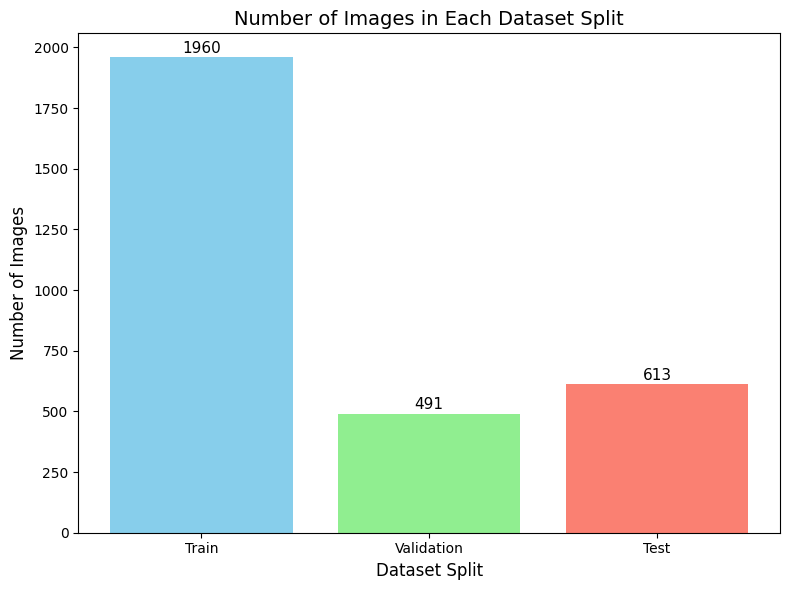

In [12]:
import matplotlib.pyplot as plt

# Count number of samples in each set
train_count = X_train.shape[0]
val_count = X_val.shape[0]
test_count = X_test.shape[0]

# Labels and counts
labels = ['Train', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Number of Images in Each Dataset Split', fontsize=14)
plt.xlabel('Dataset Split', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Annotate each bar with its count
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


## Metrics and Constructing the model

In [13]:
# Model blocks

# Convolutional block
def double_conv_block(x, n_filters):
    x = Conv2D(n_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Downsampling block
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = MaxPool2D(2)(f)  # Downsample with max pooling
    return f, p

# Upsampling block
def upsample_block(x, conv_features, n_filters):
    x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)  # Upsample
    x = concatenate([x, conv_features])  # Skip connection
    x = double_conv_block(x, n_filters)
    return x


In [15]:
# Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2  # Two classes: Tumor and Background
    total_loss = 0
    
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        if i == 0:
            total_loss = loss
        else:
            total_loss += loss
            
    return total_loss / class_num


# Precision
def precision(y_true, y_pred):
    class_num = 2
    total_precision = 0
    
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.round(K.flatten(y_pred[:, :, :, i]))  # Convert to binary
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum((1 - y_true_f) * y_pred_f)
        precision_value = tp / (tp + fp + K.epsilon())
        
        if i == 0:
            total_precision = precision_value
        else:
            total_precision += precision_value
    
    return total_precision / class_num


# Recall
def recall(y_true, y_pred):
    class_num = 2
    total_recall = 0
    
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.round(K.flatten(y_pred[:, :, :, i]))  # Convert to binary
        tp = K.sum(y_true_f * y_pred_f)
        fn = K.sum(y_true_f * (1 - y_pred_f))
        recall_value = tp / (tp + fn + K.epsilon())
        
        if i == 0:
            total_recall = recall_value
        else:
            total_recall += recall_value
    
    return total_recall / class_num


# Intersection over Union (IoU)
def iou(y_true, y_pred):
    class_num = 2
    total_iou = 0
    
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.round(K.flatten(y_pred[:, :, :, i]))  # Convert to binary
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
        iou_value = intersection / (union + K.epsilon())
        
        if i == 0:
            total_iou = iou_value
        else:
            total_iou += iou_value
    
    return total_iou / class_num


# Accuracy
def accuracy(y_true, y_pred):
    class_num = 2
    total_acc = 0

    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.round(K.flatten(y_pred[:, :, :, i]))  # Convert to binary

        correct_predictions = K.sum(K.cast(K.equal(y_true_f, y_pred_f), K.floatx()))  # Convert bool to float
        total_pixels = K.cast(K.shape(y_true_f)[0], K.floatx())  # Convert shape to float
        acc_value = correct_predictions / (total_pixels + K.epsilon())

        if i == 0:
            total_acc = acc_value
        else:
            total_acc += acc_value

    return total_acc / class_num



# Add metrics to model
metrics = [dice_coef, precision, recall, iou, accuracy]

LR =0.0001
optimizer = Adam(LR)
activation = 'sigmoid'
loss ='binary_crossentropy'


img_size = (256, 256, 3)  # Image input size

def build_unet_model(img_size, num_classes):
    # Input layer
    inputs = Input(shape=img_size)

    # Encoder
    f1, p1 = downsample_block(inputs, 64)    # Downsample 1
    f2, p2 = downsample_block(p1, 128)       # Downsample 2
    f3, p3 = downsample_block(p2, 256)       # Downsample 3
    f4, p4 = downsample_block(p3, 512)       # Downsample 4

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512) # Upsample 1
    u7 = upsample_block(u6, f3, 256)         # Upsample 2
    u8 = upsample_block(u7, f2, 128)         # Upsample 3
    u9 = upsample_block(u8, f1, 64)          # Upsample 4

    # Output layer
    outputs = Conv2D(num_classes, 1, padding="same", activation=activation)(u9)

    # Build model
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    # Compile the model with updated metrics
    unet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    return unet_model


In [16]:
# Model

# Clear session to free up RAM if the model cell was run multiple times
K.clear_session()
num_classes=2
# Build the U-Net model
unet_model = build_unet_model(img_size, num_classes)

# Print model summary
unet_model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 34,536,962 (131.75 MB)

 Trainable params: 34,525,186 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Data Augmentation

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
import albumentations as A

# Define Augmentations using Albumentations (recommended for segmentation)
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5)
])

In [19]:
# Custom Generator
class DataGenerator(Sequence):
    def __init__(self, images, masks, batch_size=10, augment=False, shuffle=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        # Select batch indexes
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[indexes]
        batch_masks = self.masks[indexes]

        # Apply augmentation if enabled
        if self.augment:
            batch_images, batch_masks = self.__augment_batch(batch_images, batch_masks)

        return np.array(batch_images), np.array(batch_masks)

    def __augment_batch(self, images, masks):
        augmented_images, augmented_masks = [], []
        for img, mask in zip(images, masks):
            augmented = augmentation(image=img, mask=mask)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])
        return np.array(augmented_images), np.array(augmented_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [20]:
# Create Generators
train_generator = DataGenerator(X_train, train_masks_cat, batch_size=10, augment=True)
val_generator = DataGenerator(X_val, val_masks_cat, batch_size=10, augment=False)

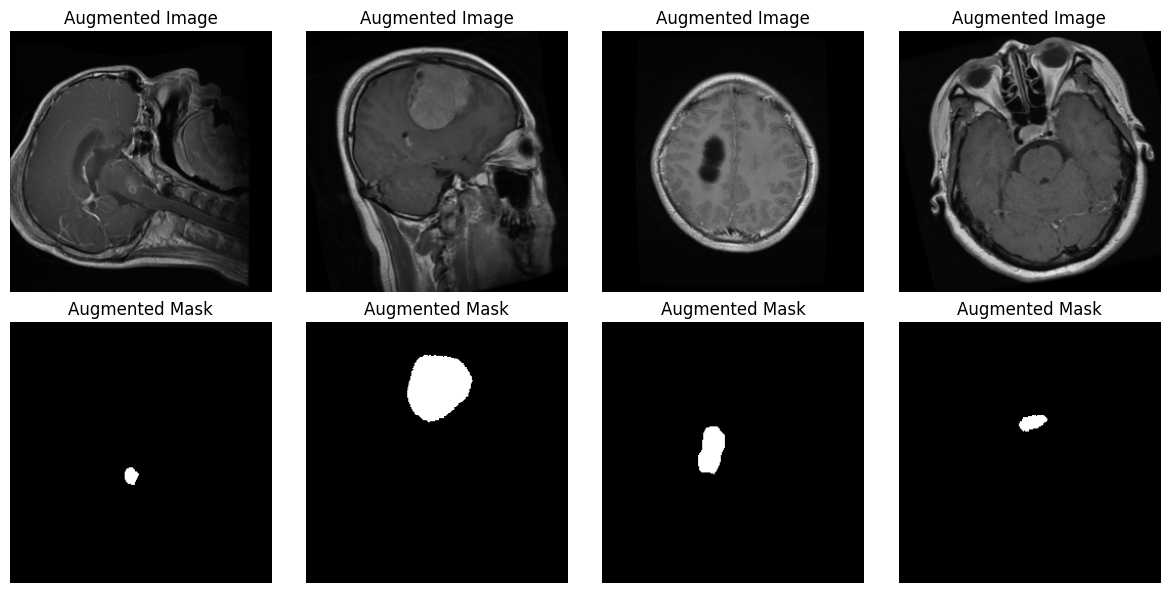

In [22]:
import matplotlib.pyplot as plt

# Get one batch from the generator with augmentations
aug_images, aug_masks = train_generator[0]

# Number of samples to show
n_samples = 4

plt.figure(figsize=(12, 6))

for i in range(n_samples):
    # Show image
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(aug_images[i].astype(np.uint8))
    plt.title('Augmented Image')
    plt.axis('off')

    # Show mask
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.imshow(np.argmax(aug_masks[i], axis=-1), cmap='gray')  # convert one-hot to class index
    plt.title('Augmented Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

# Stop training early if validation loss doesn't improve for 5 epochs
earlystopper = EarlyStopping(patience=5, verbose=1)

# Save the best model weights only during training
checkpointer = ModelCheckpoint(filepath='/kaggle/working/Model_seg.weights.h5',
                               verbose=1,
                               save_best_only=True, save_weights_only=True)

# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=3, min_lr=0.000001,
                              verbose=1, cooldown=1)


## Train the model

In [77]:
# Train Model with Augmentation
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[earlystopper, checkpointer, reduce_lr]
)


Epoch 1/30
196/196 [==============================] - ETA: 0s - loss: 0.3641 - dice_coef: 0.4282
Epoch 1: val_loss improved from inf to 0.36026, saving model to /kaggle/working/Model_seg.h5
196/196 [==============================] - 155s 750ms/step - loss: 0.3641 - dice_coef: 0.4282 - val_loss: 0.3603 - val_dice_coef: 0.4325 - lr: 1.0000e-04
Epoch 2/30
196/196 [==============================] - ETA: 0s - loss: 0.2259 - dice_coef: 0.4622
Epoch 2: val_loss improved from 0.36026 to 0.23558, saving model to /kaggle/working/Model_seg.h5
196/196 [==============================] - 150s 763ms/step - loss: 0.2259 - dice_coef: 0.4622 - val_loss: 0.2356 - val_dice_coef: 0.4638 - lr: 1.0000e-04
Epoch 3/30
196/196 [==============================] - ETA: 0s - loss: 0.1675 - dice_coef: 0.4904
Epoch 3: val_loss improved from 0.23558 to 0.16047, saving model to /kaggle/working/Model_seg.h5
196/196 [==============================] - 142s 723ms/step - loss: 0.1675 - dice_coef: 0.4904 - val_loss: 0.1605 -

## Visualization

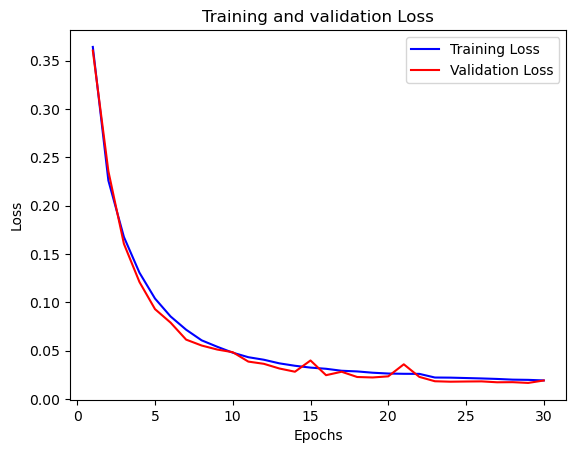

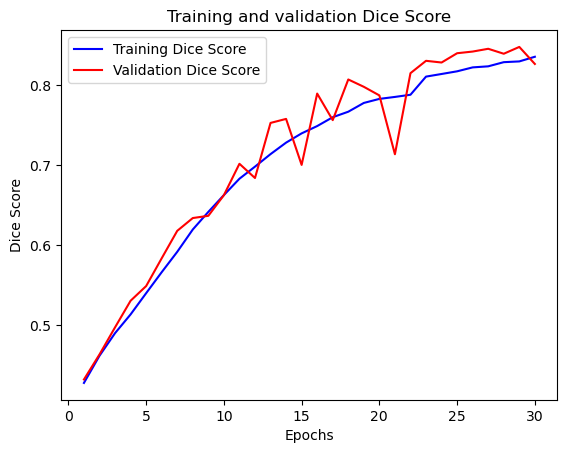

In [79]:
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation Dice score
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.plot(epochs, dice, 'b', label='Training Dice Score')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Score')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

## Testing

In [24]:


# Evaluate the model on the test dataset
print("Evaluate on test data")
results = unet_model.evaluate(X_test, test_masks_cat, batch_size=10)


Evaluate on test data
62/62 [==============================] - 14s 115ms/step - loss: 0.0187 - dice_coef: 0.8370 - precision: 0.9308 - recall: 0.8692 - iou: 0.8288 - accuracy: 0.9935


1/1 [==============================] - 0s 22ms/step


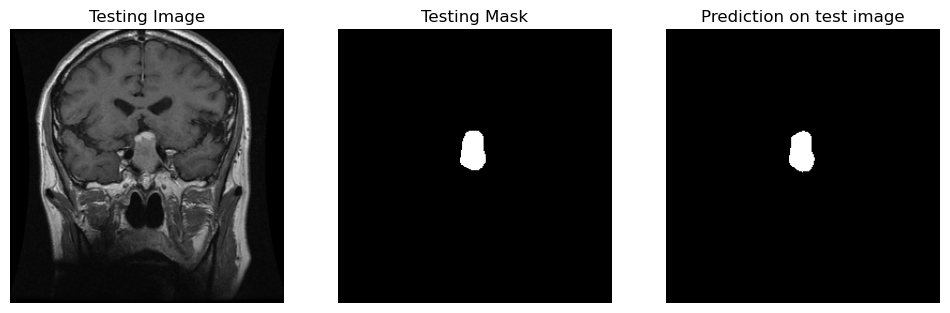

In [118]:
# Random test image and mask
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]

# Prepare input and predict
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0, :, :]

# Plot image, mask, and prediction
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 8), ncols=3)
ax1.imshow(test_img[:, :, 0], cmap='gray')
ax1.axis('off')
ax1.set_title('Testing Image')

ax2.imshow(test_mask[:, :, 0], cmap='gray')
ax2.axis('off')
ax2.set_title('Testing Mask')

ax3.imshow(test_prediction1, cmap='gray')
ax3.axis('off')
ax3.set_title('Prediction')

plt.show()


In [115]:
# Save the model to an H5 file
unet_model.save('Model_Segmentation.h5')